<a href="https://colab.research.google.com/github/akshgit10/DataAnalysis/blob/main/RetailsalesAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📂 Upload 'Online Retail.xlsx'


Saving Online Retail.xlsx to Online Retail (1).xlsx


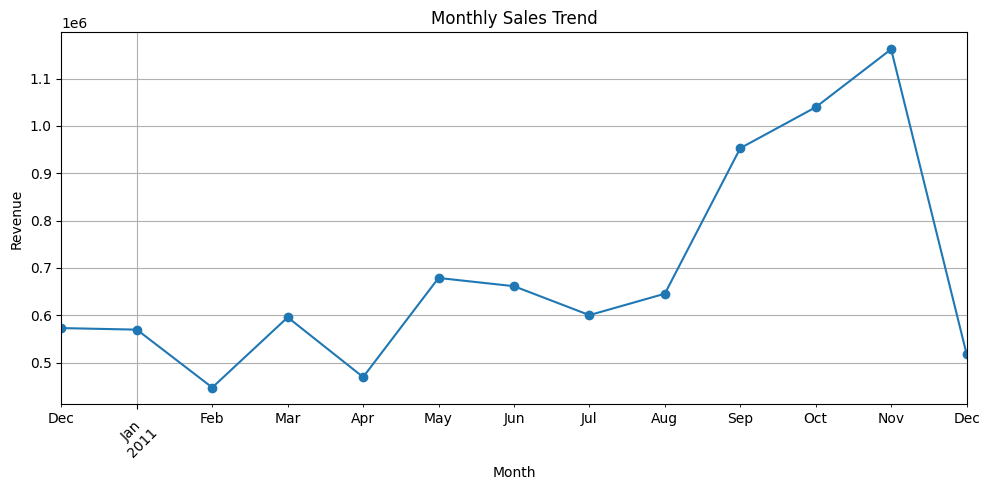

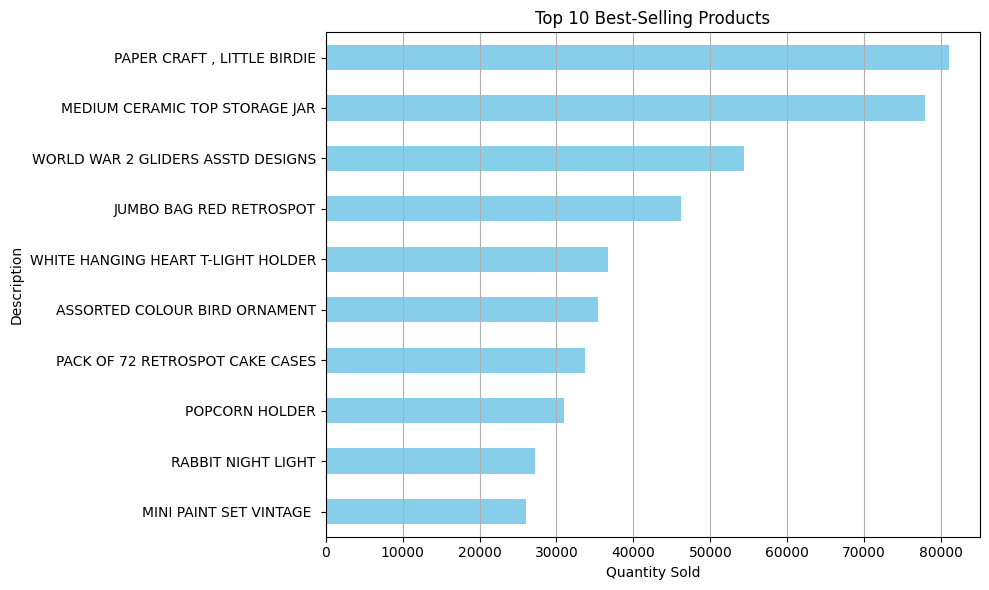

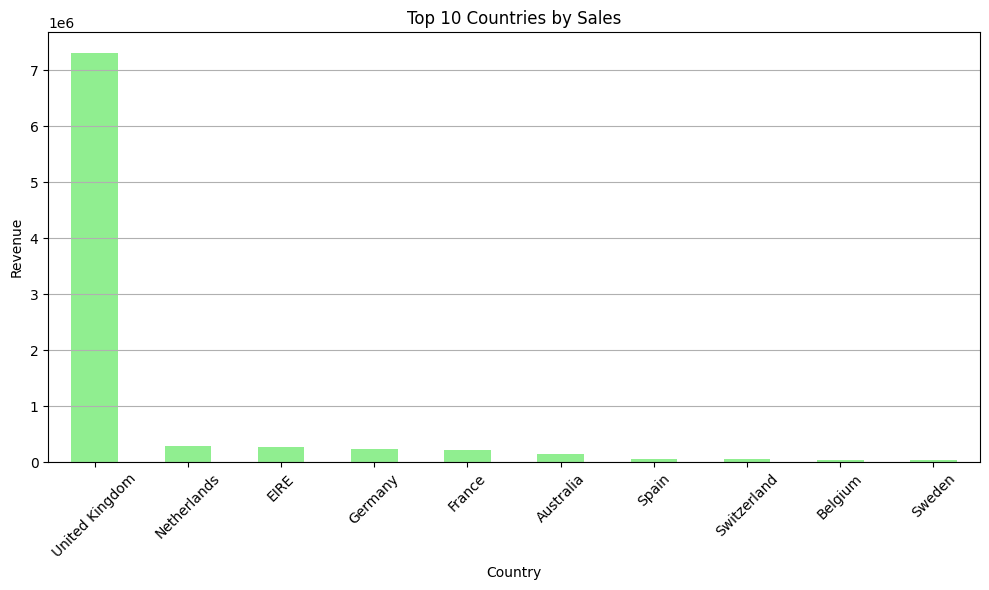


RFM Summary:
         CustomerID      Recency    Frequency       Monetary
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    92.536422     4.272015    2054.266460
std     1721.808492   100.014169     7.697998    8989.230441
min    12346.000000     1.000000     1.000000       3.750000
25%    13813.250000    18.000000     1.000000     307.415000
50%    15299.500000    51.000000     2.000000     674.485000
75%    16778.750000   142.000000     5.000000    1661.740000
max    18287.000000   374.000000   209.000000  280206.020000


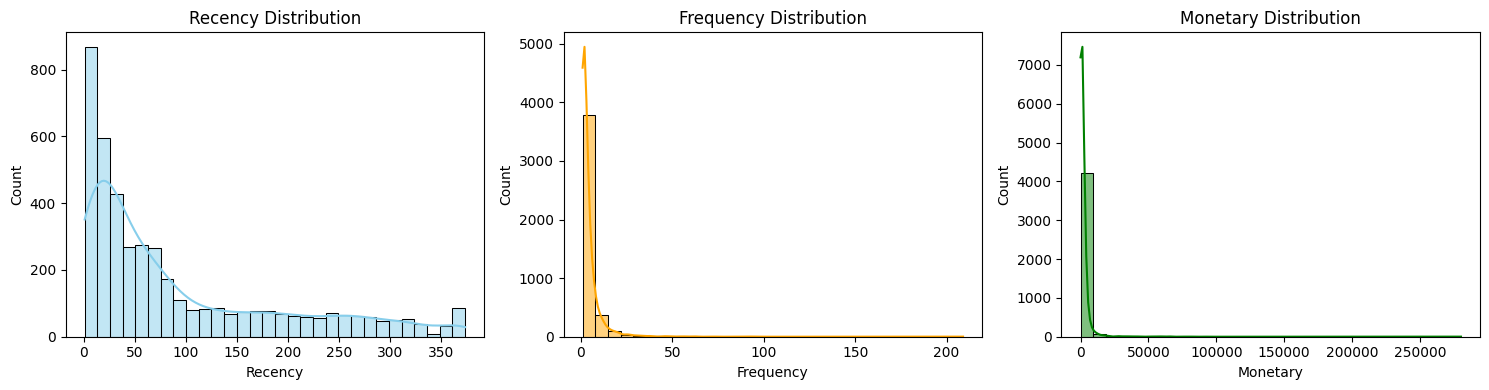

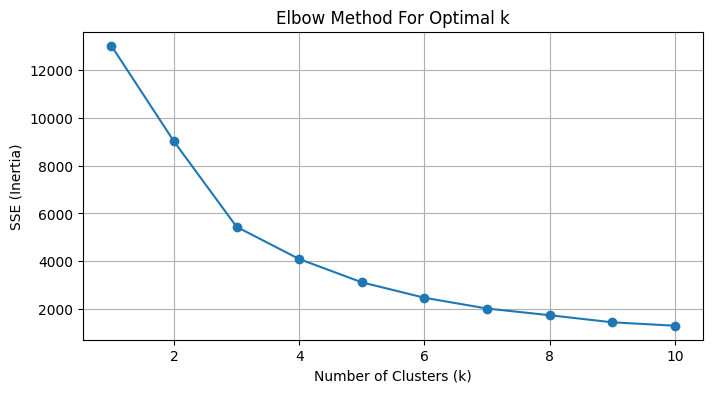

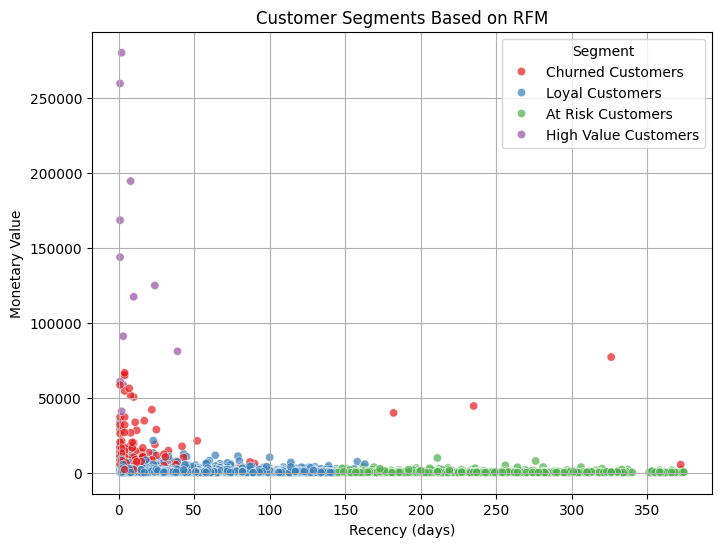


Segmented RFM data saved to RFM_Clusters.csv


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from google.colab import files
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
%matplotlib inline


print("📂 Upload 'Online Retail.xlsx'")
uploaded = files.upload()
df = pd.read_excel(next(iter(uploaded)))
df.dropna(subset=['CustomerID'], inplace=True)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('InvoiceMonth')['TotalPrice'].sum()
plt.figure(figsize=(10,5))
monthly_sales.plot(kind='line', marker='o')
plt.title('Monthly Sales Trend')
plt.ylabel('Revenue')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,6))
top_products.plot(kind='barh', color='skyblue')
plt.title('Top 10 Best-Selling Products')
plt.xlabel('Quantity Sold')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.tight_layout()
plt.show()
country_sales = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,6))
country_sales.plot(kind='bar', color='lightgreen')
plt.title('Top 10 Countries by Sales')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

NOW = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (NOW - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
print("\nRFM Summary:")
print(rfm.describe())
plt.figure(figsize=(15,4))
plt.subplot(1, 3, 1)
sns.histplot(rfm['Recency'], bins=30, color='skyblue', kde=True)
plt.title('Recency Distribution')
plt.subplot(1, 3, 2)
sns.histplot(rfm['Frequency'], bins=30, color='orange', kde=True)
plt.title('Frequency Distribution')
plt.subplot(1, 3, 3)
sns.histplot(rfm['Monetary'], bins=30, color='green', kde=True)
plt.title('Monetary Distribution')
plt.tight_layout()
plt.show()
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])
sse = []
for k in range(1, 11):
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    model.fit(rfm_scaled)
    sse.append(model.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)
cluster_labels = {
    0: "Loyal Customers",
    1: "At Risk Customers",
    2: "High Value Customers",
    3: "Churned Customers"
}
rfm['Segment'] = rfm['Cluster'].map(cluster_labels)
plt.figure(figsize=(8,6))
sns.scatterplot(x=rfm['Recency'], y=rfm['Monetary'], hue=rfm['Segment'], palette='Set1', alpha=0.7)
plt.title('Customer Segments Based on RFM')
plt.xlabel('Recency (days)')
plt.ylabel('Monetary Value')
plt.legend(title='Segment')
plt.grid(True)
plt.show()
rfm.to_csv("RFM_Clusters.csv", index=False)
print("\nSegmented RFM data saved to RFM_Clusters.csv")
